In [1]:
!pip install bayesian-optimization
import pandas as pd
from xgboost import XGBClassifier, cv
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import numpy as np

SEED=0


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Load the dataset
- Load data from excel sheet
- Set X (independent variables) and y (dependent variables) 

In [2]:
dataset='Modred'
data_path = './data/master_4Mayhew.xlsx'
df = pd.read_excel(data_path)
df.set_index('SMILES', inplace=True)
df.describe()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,...,865.000000,865.000000,865.000000,865.000000,865.000000,865.00000,865.000000,865.000000,858.000000,865.000000
mean,7.276908,6.894335,0.104046,0.067052,12.205152,2.088981,4.152585,12.205152,1.146352,3.063640,...,8.069476,39.174177,152.287403,8.109239,221.567630,11.07052,44.917919,48.427746,4.626886,2.476895
std,3.991268,3.246953,0.394751,0.319344,6.483015,0.340398,0.665934,6.483015,0.155949,0.574341,...,1.687440,12.156193,66.800469,7.067873,328.019108,9.73424,28.066950,34.772870,1.759080,1.053846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,...,0.000000,1.000000,16.031300,3.206260,0.000000,0.00000,0.000000,0.000000,1.250000,0.000000
25%,4.352030,4.736714,0.000000,0.000000,7.878462,1.956295,3.899712,7.878462,1.095322,2.752227,...,7.601402,32.187603,106.041865,5.580192,46.000000,4.00000,24.000000,24.000000,3.361111,1.750000
50%,6.801520,6.765664,0.000000,0.000000,11.342564,2.124117,4.202006,11.342564,1.174300,3.124521,...,8.298291,38.565088,144.115030,6.479693,120.000000,9.00000,40.000000,41.000000,4.361111,2.333333
75%,8.900428,8.519427,0.000000,0.000000,15.081987,2.292600,4.581552,15.081987,1.239221,3.395507,...,9.094144,45.012208,184.146330,8.062289,253.000000,15.00000,56.000000,62.000000,5.472222,3.000000
max,28.538901,20.779696,4.000000,4.000000,47.000875,2.724597,5.283099,47.000875,1.417947,4.523954,...,10.696050,88.394033,531.180395,126.904473,4692.000000,57.00000,194.000000,229.000000,14.375000,7.791667


# Explore the dataset

## How many missing values?

In [3]:
print(f"Number of columns with all NaNs \n{(df.isna().mean(axis=0) == 1).value_counts()}")
print(f"\n Number of columns with >0.9 NaNs \n{(df.isna().mean(axis=0) > 0.9).value_counts()}")
print(f"\n Number of columns with a NaN \n{ len(df.columns[df.isna().any()].tolist())}")

Number of columns with all NaNs 
False    1735
True       92
dtype: int64

 Number of columns with >0.9 NaNs 
False    1667
True      160
dtype: int64

 Number of columns with a NaN 
623


### Visualise number of NaNs in descriptors with missing values 

Text(0.5, 0, 'Percentage NaNs in descriptors with missing values')

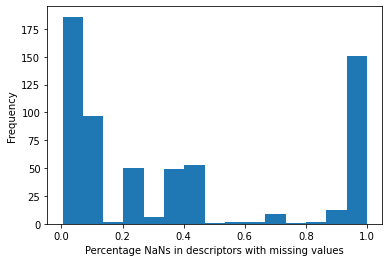

In [4]:
percs = df.isna().mean(axis=0)

ax = percs[(percs > 0)].plot.hist(bins=15)
plt.xlabel("Percentage NaNs in descriptors with missing values")

## Correlation between the descriptors

- degree to which features are related 
- https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

In [5]:
corrs = df.corr()

In [6]:
corrs.to_csv(f'results/correlations/descriptor-correlations-{dataset}.csv')  

### Extract correlation scores for important features

In [7]:
def corrs_important_features(model, X_test, model_name, nlargest=100, heatmap=14):
    feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
    top_100 = feature_imp.nlargest(100)
    important_df = df.loc[:,top_100.index]
    corrs = important_df.corr()
    
    print(f"Extracted correlation scores for most important {nlargest} features for {model_name}")
    corrs.to_csv(f'results/correlations/descriptor-corrs-top{nlargest}-{model_name}-{dataset}.csv')  
    
    # Print heatmap for top n
    print(f"Printing heatmap for most important {heatmap} features")
    
    top_10 = feature_imp.nlargest(heatmap)
    important_df_10 = df.loc[:,top_10.index]
    corrs_10 = important_df_10.corr()
    
    plt.figure(figsize = (16,16))
    heatmap = sns.heatmap(corrs_10, vmin=-1, vmax=1, annot=True)
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Preprocessing

In [8]:
# Correlation

corrs = df.corr()
# select upper traingle of correlation matrix
upper = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(bool))
# Find index of columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
# drop the columns
df.drop(to_drop, axis=1, inplace=True)

# Remove descriptors with all NaNs 

df.dropna(axis=1, how='all', inplace=True)

In [9]:
df

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,PetitjeanIndex,SRW03,SRW05,SRW07,TSRW10,WPath,WPol,mZagreb1,mZagreb2,label
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,10.191572,9.610016,0,0,16.402096,2.535251,1.261700,3.521954,3.285911,0.252762,...,0.400000,0.0,2.397895,5.043425,60.186518,209,23,5.506944,2.750000,False
C(=C(F)F)(C(F)(F)F)C(F)(F)F,8.786807,9.354315,0,0,11.264384,2.394170,0.938699,3.353751,3.104170,0.258681,...,0.500000,0.0,0.000000,0.000000,43.053817,179,16,8.347222,2.444444,False
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],11.877237,11.411786,0,0,18.380381,2.411142,1.148774,3.664511,3.560472,0.222529,...,0.333333,0.0,0.000000,0.000000,48.280750,408,25,8.277778,3.555556,False
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,15.682318,12.964430,0,0,26.034025,2.456696,1.301701,3.935426,4.013953,0.200698,...,0.500000,0.0,0.000000,2.708050,61.882766,726,36,6.277778,4.388889,False
C(C(C(F)(F)F)(F)Cl)(F)Cl,7.220990,7.794227,0,0,9.758256,2.380983,0.975826,3.172059,2.850208,0.285021,...,0.500000,0.0,0.000000,0.000000,40.351995,108,15,7.236111,2.062500,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,5.766244,6.059284,0,0,10.383983,2.015316,1.153776,3.007982,2.728364,0.303152,...,0.428571,0.0,0.000000,0.000000,35.041491,108,7,4.361111,2.416667,True
C=CCSS(=O)CC=C,5.766244,6.059284,0,0,10.383983,2.015316,1.153776,3.007982,2.728364,0.303152,...,0.428571,0.0,0.000000,0.000000,35.041491,108,7,4.361111,2.416667,True
CCCC(=O)OCC(C)C,6.692130,6.855805,0,0,11.127090,2.052881,1.112709,3.123647,2.924848,0.292485,...,0.428571,0.0,0.000000,0.000000,37.120200,143,8,5.222222,2.500000,True


# Split the dataset
- Split dataset into training and test set 
- Use equal proportions of odor/odorless class

In [10]:
y=df['label'] # labels, independent variables
X=df.drop(['label'], axis=1) # features, dependent variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) # 70% training and 30% test
percentage_odorless = y_train.value_counts()[False]/y_train.shape[0]
percentage_odor = 1 - percentage_odorless
print(f"Total number molecules in training set: {y_train.shape[0]}")
print(f"Odor: {y_train.value_counts()[True]}")
print(f"Odorless: {y_train.value_counts()[False]}")

print(f"\nTotal number molecules in test set: {y_test.shape[0]}")
print(f"Odor: {y_test.value_counts()[True]}")
print(f"Odorless: {y_test.value_counts()[False]}")

print(f"\nPercentage odorless {y_test.value_counts()[False]/y_test.shape[0]}")

Total number molecules in training set: 692
Odor: 492
Odorless: 200

Total number molecules in test set: 173
Odor: 123
Odorless: 50

Percentage odorless 0.28901734104046245


### Validation set

In [11]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=SEED)

print("Number of training samples:", len(X_train_t))
print("Number of validation samples:", len(X_val))

Number of training samples: 484
Number of validation samples: 208


## More preprocessing

In [12]:
from sklearn import preprocessing 

# Scale dataset 

min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = min_max_scaler.fit_transform(X_train)

X_train =  pd.DataFrame(X_train_transformed, columns=X_train.columns[0:], index=X_train.index)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns[0:], index=X_test.index)

min_max_scaler2 = preprocessing.MinMaxScaler()
X_train_t_transformed = min_max_scaler2.fit_transform(X_train_t)

X_train_t = pd.DataFrame(X_train_t_transformed, columns=X_train_t.columns[0:], index=X_train_t.index)
X_val = pd.DataFrame(min_max_scaler2.transform(X_val), columns=X_val.columns[0:], index=X_val.index)

X_train

/home/zoya/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/zoya/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/zoya/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/zoya/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,TopoShapeIndex,PetitjeanIndex,SRW03,SRW05,SRW07,TSRW10,WPath,WPol,mZagreb1,mZagreb2
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.309821,0.394293,0.25,0.00,0.306024,0.836239,0.845317,0.700279,0.570654,0.172701,...,0.75,0.857143,0.000000,0.000000,0.000000,0.471807,0.043905,0.263158,0.319577,0.349376
CCCCCCCCCCCCCCCCO,0.396431,0.452955,0.00,0.00,0.443824,0.722902,0.865381,0.770472,0.720222,0.122062,...,1.00,1.000000,0.000000,0.000000,0.000000,0.512619,0.173913,0.245614,0.342857,0.577540
C1(C(O1)(F)F)(C(F)(F)F)F,0.274541,0.413249,0.00,0.00,0.218073,0.974090,0.722849,0.684785,0.457935,0.183786,...,1.00,1.000000,0.660876,0.888838,0.969153,0.711012,0.022379,0.228070,0.395238,0.240642
CC(C)(C=C)O,0.140590,0.206202,0.00,0.00,0.123798,0.761328,0.683926,0.504650,0.329480,0.299484,...,0.50,0.666667,0.000000,0.000000,0.000000,0.350883,0.005968,0.052632,0.233333,0.176471
C=CCC1=CC2=C(C=C1)OCO2,0.320683,0.401337,0.00,0.00,0.333378,0.867138,0.920877,0.712446,0.558353,0.168176,...,0.75,0.857143,0.000000,0.500000,0.693146,0.631957,0.041986,0.245614,0.158730,0.356506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.099108,0.151411,0.00,0.00,0.116255,0.635709,0.770706,0.442993,0.295956,0.356088,...,1.00,1.000000,0.000000,0.000000,0.000000,0.281290,0.004263,0.035088,0.114286,0.192513
CCN(CC)CC,0.148662,0.233879,0.00,0.25,0.170210,0.734054,0.805994,0.537825,0.371512,0.264419,...,1.00,1.000000,0.000000,0.000000,0.000000,0.354044,0.010230,0.105263,0.198942,0.256684
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.372653,0.442597,0.00,0.00,0.400304,0.846823,0.947780,0.748015,0.637485,0.150314,...,1.00,1.000000,0.000000,0.000000,0.000000,0.505957,0.065431,0.315789,0.196825,0.413547


# Test Model 

In [13]:
def test_model(model, y_test, X_test, verbose=True):
    y_pred=model.predict(X_test)
    y_pred_probs=model.predict_proba(X_test)[:,1]
    
    if verbose:
        print("ROC_AUC (TEST):",metrics.roc_auc_score(y_test, y_pred_probs))
        print("\n\nCLASSIFICATION REPORT:\n",metrics.classification_report(y_test, y_pred))
        
        if hasattr(model, 'feature_importances_') and hasattr(X_test, 'columns'):
            feature_imp = pd.Series(model.feature_importances_,index=X_test.columns.values).sort_values(ascending=False)
            top_20 = feature_imp.nlargest(20)
            sns.barplot(x=top_20, y=top_20.index)
            plt.xlabel('Descriptor Importance Score')
            plt.ylabel('Descriptor')
            plt.title("Top descriptors")
            plt.show()
        
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probs)  
        
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    return metrics.roc_auc_score(y_test, y_pred_probs)

In [14]:
def test_model_cross_val(model, y_test, X_test, k=5, verbose=True):
    roc_auc_nans = cross_val_score(model, X_test, y_test, cv=k, scoring='roc_auc')
    print(f"AVERAGE CV={k} ROC_AUC: {np.mean(roc_auc_nans)}")
    print(f"AVERAGE CV={k} STD: {np.std(roc_auc_nans)}")
    return np.mean(roc_auc_nans), np.std(roc_auc_nans)

# Handle Non Important Descriptors 

1. Remove values below threshold e.g. 0, any descriptors with 0 importance
2. Get the top N descriptors

In [15]:
def handle_importance(model, X_train, X_test=pd.DataFrame(), threshold=-1, n=-1, verbose=None):
    feature_imp = pd.Series(model.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
    if threshold >= 0:
        feature_imp = feature_imp[feature_imp > threshold]
    
    if n >= 0: 
        feature_imp = feature_imp.nlargest(n)
        
    if verbose: 
        print(feature_imp)
        
    X_train = X_train.loc[:, feature_imp.axes[0].tolist()]
    
    if not X_test.empty:
        X_test = X_test.loc[:, feature_imp.axes[0].tolist()]

    return X_train, X_test, model 

In [16]:
def optimiseImportance(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    
    imp_params = [
              {"threshold":-1, 'n':1},
              {"threshold":-1, 'n':2},
              {"threshold":-1, 'n':5}, 
              {"threshold":-1, 'n':10}, 
              {"threshold":-1, 'n':25}, 
              {"threshold":-1, 'n':50},
              {"threshold":-1, 'n':100}, 
              {"threshold":-1, 'n':200}, 
              {"threshold":-1, 'n':400},
              {"threshold":-1, 'n':X_tr.shape[1]}]
    
    sns.set(rc={'figure.figsize':(11.7,12.27)})
    feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
    top_50 = feature_imp.nlargest(50)
    sns.barplot(x=top_50, y=top_50.index)
    plt.xlabel('Descriptor Importance Score')
    plt.ylabel('Descriptor')
    plt.title("Top 50 descriptors")
    plt.show()

    print(f"Cross validated importance experiment with k={k}")
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}N:{imp_param['n']}".replace("N:-1", '')).replace("Threshold:-1", '')
        
        X_tr_temp , _, _ = handle_importance(model, 
                                            X_tr.copy(), 
                                            threshold=imp_param['threshold'], 
                                            n=imp_param['n'])
                
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar", x="Most important N descriptors", y="Average AUROC", 
                          yerr="Standard Deviation", 
                          figsize=(8,5),
                          title=f"AUROC after filtering descriptors by importance CV={k} - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
    return imp_df

In [17]:
def testWithoutImportantDescs(model, X_tr, y_tr, k=5, model_name="RF", verbose=True):
    imp_params = [
                  {"threshold":-1, 'n':5}, 
                  {"threshold":-1, 'n':10}, 
                  {"threshold":-1, 'n':25}, 
                  {"threshold":-1, 'n':50},
                  {"threshold":-1, 'n':100}, 
                  {"threshold":-1, 'n':200}, 
                  {"threshold":-1, 'n':400}]
    
    imp_df = pd.DataFrame(columns=['Most important N descriptors', 'Average AUROC', 'Standard Deviation'])

    roc_auc, std = test_model_cross_val(model, y_tr, X_tr)
    imp_df = imp_df.append({'Most important N descriptors': 0, 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

    
    for imp_param in imp_params: 
        name = (f"Threshold:{imp_param['threshold']}")

        feature_imp = pd.Series(model.feature_importances_,index=X_tr.columns.values).sort_values(ascending=False)
        feature_imp = feature_imp.nlargest(imp_param['n'])
        X_tr_temp = X_tr.drop(feature_imp.axes[0].tolist(), axis=1) 
        roc_auc_nans = cross_val_score(model, X_tr_temp, y_tr, cv=k, scoring='roc_auc')
        
        imp_df = imp_df.append({'Most important N descriptors': imp_param['n'], 
                               'Average AUROC':np.mean(roc_auc_nans), 
                               'Standard Deviation':np.std(roc_auc_nans)}, 
                                ignore_index = True)

    if verbose:
        fig = imp_df.plot(kind="bar",figsize=(8,5), x="Most important N descriptors", y="Average AUROC",  ylabel="Average AUROC",  yerr="Standard Deviation", title=f"AUROC after removing descriptors by importance CV={k}  - {model_name} - {dataset}", legend=False)
        plt.ylim(0.80,1)
        
    return imp_df

# Handle NaNs


- You cannot have any missing values in the random forest model, you can in XGB
- You cannot have mismatched features between columns in the random forest model
- 3 options 
    1. Remove any columns with missing values 
    2. Remove columns above threshold percentange NaNs e.g. 60% NaNs. 
    3. Remove columns above threshold percentange NaNs e.g. 60% NaNs. Replace columns below threshold with missing values with the mean value.

In [18]:
from sklearn.impute import KNNImputer

def handleNaNs(X_tr, X_te, option=1, thresh=0.6): 
    if option == 1:
        nans =  X.columns[X.isna().any()].tolist()
        X_tr.drop(nans, inplace = True, axis=1)
        X_te.drop(nans, inplace = True, axis=1)
    else: 
        nans = X.isna().mean(axis=0)
        # set threshold for percentage nans before we drop 
        X_thresh = nans[nans >= thresh]
        X_tr.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        X_te.drop(X_thresh.index, 
          axis=1, 
          inplace=True)
        
        if option == 3: 
            imputer = KNNImputer(n_neighbors=2)
            X_tr_temp = imputer.fit_transform(X_tr)
            X_te_temp = imputer.transform(X_te)
            
            X_tr =  pd.DataFrame(X_tr_temp, columns=X_tr.columns[0:], index=X_tr.index)
            X_te = pd.DataFrame(X_te_temp, columns=X_te.columns[0:], index=X_te.index)
    
    return X_tr, X_te

In [19]:
def optimiseNaNs(model, X_train, X_test, y_train, y_test, model_name="RF", option=2, k=5, verbose=True): 
    print(f"Cross validated missing values experiment with k={k}")
    
    percentages = [x/100 for x in range(0, 100, 10)] 
    nans_df = pd.DataFrame(columns=['Percentage', 'Average AUROC', 'Standard Deviation'])

    for perc in percentages: 
        name = str(perc)
        if perc == 0:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=1)
        else:
            X_train_cv, _  = handleNaNs(X_train.copy(), X_test.copy(), option=option, thresh=perc)

        roc_auc_nans = cross_val_score(model, X_train_cv, y_train, cv=k, scoring='roc_auc')
        
        nans_df = nans_df.append({'Percentage': name, 
                                   'Average AUROC':np.mean(roc_auc_nans), 
                                   'Standard Deviation':np.std(roc_auc_nans)}, 
                                    ignore_index = True)

    if verbose:
        fig = nans_df.plot(kind="bar", x="Percentage", y="Average AUROC", ylabel="Average AUROC", 
                           yerr="Standard Deviation", title=f"AUROC after thresholding descriptors by % NaNs CV={k} - {model_name} - {dataset}", 
                           legend=False)
        plt.ylim(0.9,1)
        
    return nans_df

# Random Forest Model

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [20]:
clf=RandomForestClassifier(random_state=SEED) 

# For readability
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

## Handle NaNs RF

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.970754,0.004396
1,0.1,0.965088,0.005192
2,0.2,0.968645,0.003966
3,0.3,0.966292,0.003755
4,0.4,0.965518,0.004285
5,0.5,0.963837,0.004596
6,0.6,0.965342,0.002749
7,0.7,0.967077,0.003952
8,0.8,0.965316,0.002013
9,0.9,0.968259,0.005583


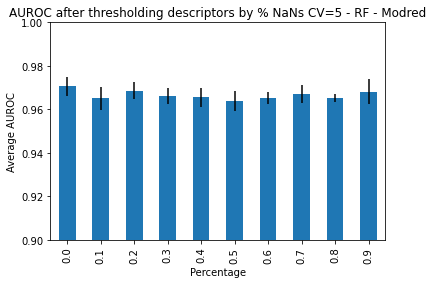

In [21]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(clf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, option=3)

It seems to have a very high standard deviation, so let's just go with removing all the columns with missing values

In [22]:
X_train_rf, X_test_rf = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_rf, X_val_rf = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

In [23]:
X_train_rf

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,JGT10,Diameter,Radius,SRW03,SRW05,SRW07,TSRW10,WPath,WPol,mZagreb2
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.309821,0.394293,0.25,0.00,0.306024,0.836239,0.845317,0.700279,0.570654,0.172701,...,0.613782,0.368421,0.4,0.000000,0.000000,0.000000,0.471807,0.043905,0.263158,0.349376
CCCCCCCCCCCCCCCCO,0.396431,0.452955,0.00,0.00,0.443824,0.722902,0.865381,0.770472,0.720222,0.122062,...,0.086322,0.842105,0.8,0.000000,0.000000,0.000000,0.512619,0.173913,0.245614,0.577540
C1(C(O1)(F)F)(C(F)(F)F)F,0.274541,0.413249,0.00,0.00,0.218073,0.974090,0.722849,0.684785,0.457935,0.183786,...,0.959473,0.210526,0.2,0.660876,0.888838,0.969153,0.711012,0.022379,0.228070,0.240642
CC(C)(C=C)O,0.140590,0.206202,0.00,0.00,0.123798,0.761328,0.683926,0.504650,0.329480,0.299484,...,0.748152,0.157895,0.2,0.000000,0.000000,0.000000,0.350883,0.005968,0.052632,0.176471
C=CCC1=CC2=C(C=C1)OCO2,0.320683,0.401337,0.00,0.00,0.333378,0.867138,0.920877,0.712446,0.558353,0.168176,...,0.397004,0.368421,0.4,0.000000,0.500000,0.693146,0.631957,0.041986,0.245614,0.356506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.099108,0.151411,0.00,0.00,0.116255,0.635709,0.770706,0.442993,0.295956,0.356088,...,0.281482,0.210526,0.2,0.000000,0.000000,0.000000,0.281290,0.004263,0.035088,0.192513
CCN(CC)CC,0.148662,0.233879,0.00,0.25,0.170210,0.734054,0.805994,0.537825,0.371512,0.264419,...,0.455852,0.210526,0.2,0.000000,0.000000,0.000000,0.354044,0.010230,0.105263,0.256684
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.372653,0.442597,0.00,0.00,0.400304,0.846823,0.947780,0.748015,0.637485,0.150314,...,0.300892,0.421053,0.4,0.000000,0.000000,0.000000,0.505957,0.065431,0.315789,0.413547


In [24]:
clf.fit(X_train_rf, y_train_rf)
print("Cross validated = 5 performance of Random Forest after removing all columns with NaNs")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Cross validated = 5 performance of Random Forest after removing all columns with NaNs
AVERAGE CV=5 ROC_AUC: 0.9707539682539682
AVERAGE CV=5 STD: 0.004395835928174897


(0.9707539682539682, 0.004395835928174897)

## Using PCA to reduce dimensionality

Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.6834704184704185
AVERAGE CV=5 STD: 0.05969310253291869
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.8725752422180995
AVERAGE CV=5 STD: 0.020587874968443717
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9384268707482992
AVERAGE CV=5 STD: 0.004135516067352597
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.951801690373119
AVERAGE CV=5 STD: 0.01056983648960776
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.958683003504432
AVERAGE CV=5 STD: 0.012660873349447163
Validation performance of Random Forest after reducing dimensionality with PCA
AVERAGE CV=5 ROC_AUC: 0.9596580601937745
AVERAGE CV=5 STD: 0.010784411481882082
Validation performance of Random Forest after redu

(0.0, 1.0)

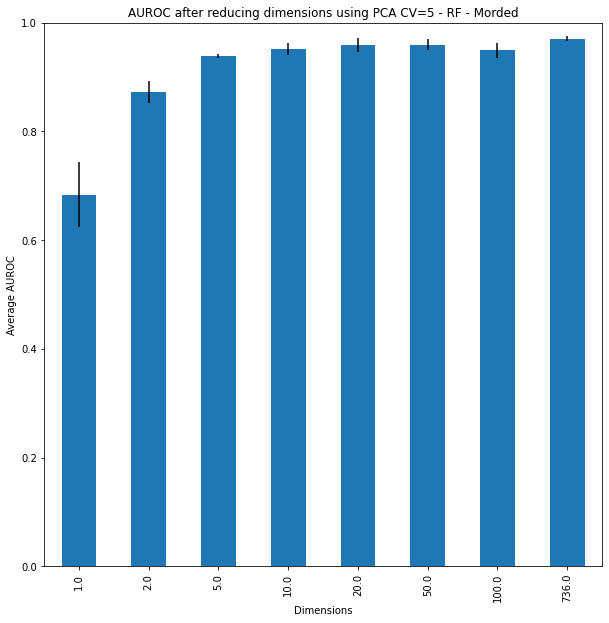

In [25]:
from sklearn import decomposition 

pca_df = pd.DataFrame(columns=['Dimensions', 'Average AUROC', 'Standard Deviation'])

roc_aucs = []
stds = []
pcas = [1, 2, 5, 10, 20, 50, 100]

for n in pcas:
    pca = decomposition.PCA(n_components=n)
    pca_result = pca.fit_transform(X_train_rf)
    clf.fit(pca_result, y_train_rf)
    
    print("Validation performance of Random Forest after reducing dimensionality with PCA")
    roc_auc, std = test_model_cross_val(clf, y_train_rf, pca_result, k=5, verbose=True)
    
    pca_df = pca_df.append({'Dimensions': n, 
                           'Average AUROC':roc_auc, 
                           'Standard Deviation':std}, 
                            ignore_index = True)

clf.fit(X_train_rf, y_train_rf)
print("Validation performance of Random Forest with all dimensions")
roc_auc, std = test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)
roc_aucs.append(roc_auc)
pca_df = pca_df.append({'Dimensions': X_train_rf.shape[-1], 
                       'Average AUROC':roc_auc, 
                       'Standard Deviation':std}, 
                        ignore_index = True)

fig = pca_df.plot(kind="bar", x="Dimensions", y="Average AUROC", ylabel="Average AUROC", 
                   yerr="Standard Deviation", title=f"AUROC after reducing dimensions using PCA CV=5 - RF - Morded", 
                   legend=False, figsize=(10, 10))

plt.ylim(0,1)
        

## Importance experiment

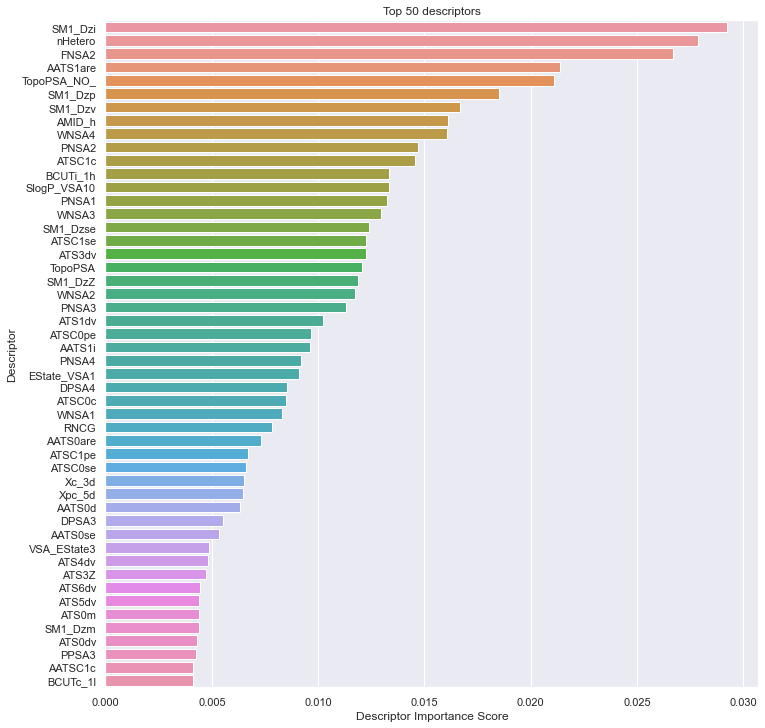

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.909049,0.027042
1,2.0,0.910372,0.020449
2,5.0,0.959256,0.004709
3,10.0,0.959360,0.002852
4,25.0,0.974702,0.002947
5,50.0,0.971111,0.007289
6,100.0,0.974286,0.002074
7,200.0,0.974709,0.002856
8,400.0,0.970748,0.004900
9,736.0,0.968215,0.004109


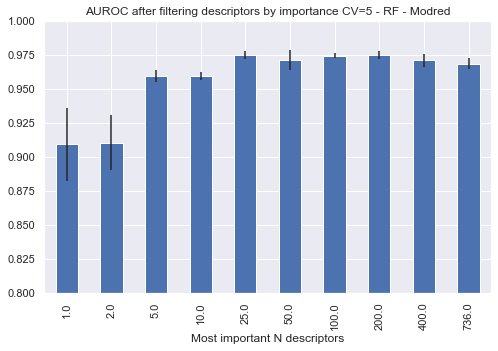

In [26]:
clf.fit(X_train_rf, y_train_rf)
optimiseImportance(clf, X_train_rf, y_train_rf)

AVERAGE CV=5 ROC_AUC: 0.9707539682539682
AVERAGE CV=5 STD: 0.004395835928174897


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.970754,0.004396
1,5.0,0.969985,0.002370
2,10.0,0.968800,0.004751
3,25.0,0.964160,0.005061
4,50.0,0.969175,0.004242
5,100.0,0.963896,0.007883
6,200.0,0.960664,0.007652
7,400.0,0.951287,0.013117


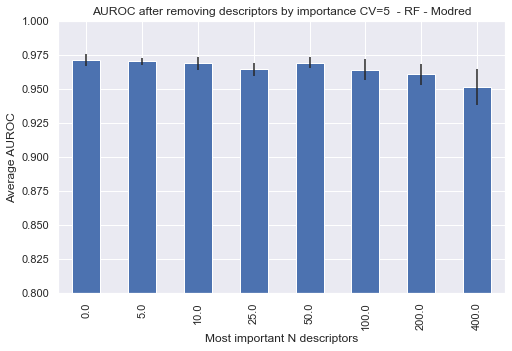

In [27]:
clf.fit(X_train_rf, y_train_rf)
testWithoutImportantDescs(clf, X_train_rf, y_train_rf)

### Remove labels 

In [28]:
clf.fit(X_train_rf, y_train_rf)
X_train_rf, X_test_rf, clf = handle_importance(clf, 
                                               X_train_rf, 
                                               X_test_rf, 
                                               threshold=-1, 
                                               n=100)

In [29]:
clf.fit(X_train_rf, y_train_rf)
print("Validation set performance of Random Forest after removing labels")
test_model_cross_val(clf, y_train_rf, X_train_rf, k=5, verbose=True)

Validation set performance of Random Forest after removing labels
AVERAGE CV=5 ROC_AUC: 0.9742857142857142
AVERAGE CV=5 STD: 0.0020740633782636206


(0.9742857142857142, 0.0020740633782636206)

In [30]:
X_train_rf

,SM1_Dzi,nHetero,FNSA2,AATS1are,TopoPSA_NO_,SM1_Dzp,SM1_Dzv,AMID_h,WNSA4,PNSA2,...,AATS0p,ETA_dPsi_A,AATSC1v,Mor18v,BCUTdv_1h,TPSA,piPC10,Xc_3dv,ATS2dv,fragCpx
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.251059,0.357143,0.694451,0.369630,0.516701,0.768469,0.676406,0.413112,0.703848,0.734250,...,0.035247,0.010616,0.958572,0.698117,0.997123,0.526246,0.000000,0.015204,0.241026,0.035402
CCCCCCCCCCCCCCCCO,0.112811,0.071429,0.934664,0.229022,0.129946,0.893573,0.855153,0.056312,0.921735,0.890581,...,0.023946,0.002182,0.935568,0.625701,0.712387,0.155062,0.202413,0.000000,0.054701,0.047046
C1(C(O1)(F)F)(C(F)(F)F)F,0.506810,0.500000,0.494475,0.607604,0.080486,0.495201,0.468501,0.672371,0.457323,0.645110,...,0.020501,0.018221,0.928123,0.760363,0.998787,0.086313,0.000000,0.027367,0.476923,0.029580
CC(C)(C=C)O,0.112811,0.071429,0.916626,0.255204,0.129946,0.893573,0.855153,0.154298,0.944837,0.941876,...,0.024147,0.005582,0.921020,0.796857,0.713536,0.117471,0.000000,0.046692,0.034188,0.014702
C=CCC1=CC2=C(C=C1)OCO2,0.144954,0.142857,0.804316,0.288925,0.118577,0.857611,0.808118,0.190069,0.825761,0.814428,...,0.036193,0.005582,0.935942,0.584429,0.855813,0.162675,0.345379,0.014284,0.202564,0.108824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.064534,0.071429,0.955343,0.213054,0.000000,0.943628,0.920763,0.188559,0.965629,0.967489,...,0.038773,0.000000,0.900442,0.807707,0.305619,0.000000,0.000000,0.000000,0.006078,0.011762
CCN(CC)CC,0.122486,0.071429,0.966395,0.238595,0.020812,0.912317,0.864545,0.163859,0.978544,0.973014,...,0.021626,0.002819,0.890375,0.783772,0.713234,0.006702,0.000000,0.009582,0.023077,0.017642
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.112811,0.071429,0.840326,0.253682,0.109648,0.893573,0.855153,0.071523,0.854472,0.839990,...,0.043110,0.002618,0.952006,0.506274,0.857299,0.086478,0.557940,0.013193,0.198291,0.126437


## Tuning the hyperparamaters 

In [31]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [32]:
params = {
    'n_estimators': (10, 2000),
    'min_samples_split': (1, 100),
    'max_depth': (3,200),
    'min_samples_leaf': (1, 10)
    }

def rf_hyper_param(n_estimators, 
                       min_samples_split, 
                       max_depth, 
                       min_samples_leaf):

    max_depth = int(max_depth)
    min_samples_leaf = int(min_samples_leaf)
    min_samples_split = int(min_samples_split)
    n_estimators = int(n_estimators)

    rf_temp = RandomForestClassifier(
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(rf_temp, X_train_rf, y_train_rf, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=rf_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9583    | 111.1     | 7.437     | 60.67     | 1.094e+03 |
| 2         | 0.9607    | 86.46     | 6.813     | 44.32     | 1.785e+03 |
| 3         | 0.9582    | 192.8     | 4.451     | 79.38     | 1.063e+03 |
| 4         | 0.9636    | 114.9     | 9.33      | 8.033     | 183.4     |
| 5         | 0.9565    | 6.983     | 8.494     | 78.04     | 1.741e+03 |
| 6         | 0.9662    | 113.8     | 7.378     | 3.534     | 173.1     |
| 7         | 0.9649    | 117.7     | 7.27      | 8.873     | 154.3     |
| 8         | 0.969     | 115.5     | 4.814     | 10.66     | 156.4     |
| 9         | 0.9653    | 109.7     | 6.044     | 16.71     | 158.8     |
| 10        | 0.9699    | 107.7     | 2.924     | 16.8      | 170.9     |
| 11        | 0.9672    | 124.0     | 5.789     | 16.74     | 167.2     |
| 12        | 0.9671    | 118.5     | 

In [33]:
params_tuned_rf = optimizer.max['params']
params_tuned_rf['max_depth'] = int(params_tuned_rf['max_depth'])
params_tuned_rf['n_estimators'] = int(params_tuned_rf['n_estimators'])
params_tuned_rf['min_samples_leaf'] = int(params_tuned_rf['min_samples_leaf'])
params_tuned_rf['min_samples_split'] = int(params_tuned_rf['min_samples_split'])

tuned_rf = RandomForestClassifier(**params_tuned_rf, random_state=SEED)
test_model_cross_val(tuned_rf, y_train_rf, X_train_rf, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9741367759224902
AVERAGE CV=5 STD: 0.0027792947524345273


(0.9741367759224902, 0.0027792947524345273)

In [34]:
print(params_tuned_rf)

{'max_depth': 140, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 174}


In [35]:
tuned_rf = RandomForestClassifier(**params_tuned_rf, random_state=SEED)
tuned_rf.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=140, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=174, random_state=0)

ROC_AUC (TEST): 0.9773983739837399


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.88      0.88      0.88        50
        True       0.95      0.95      0.95       123

    accuracy                           0.93       173
   macro avg       0.92      0.92      0.92       173
weighted avg       0.93      0.93      0.93       173



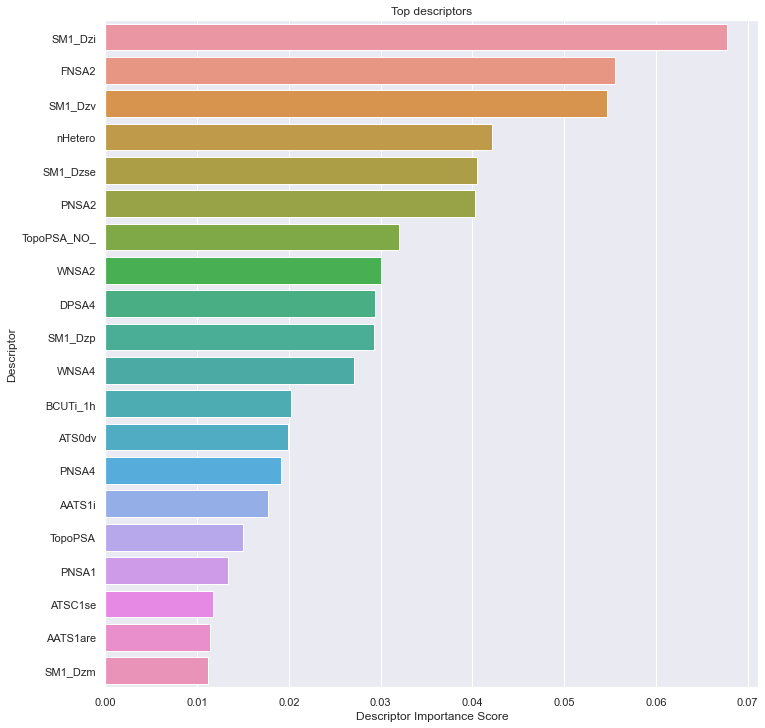

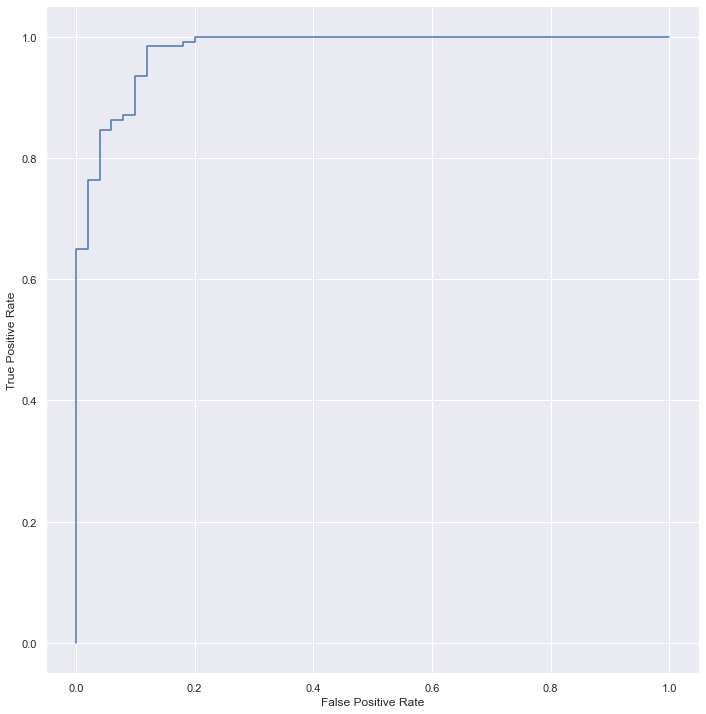

0.9773983739837399

In [36]:
tuned_rf.fit(X_train_rf, y_train_rf)
test_model(tuned_rf, y_test_rf, X_test_rf)

## Extract correlation scores for important features

Extracted correlation scores for most important 100 features for random forest
Printing heatmap for most important 15 features


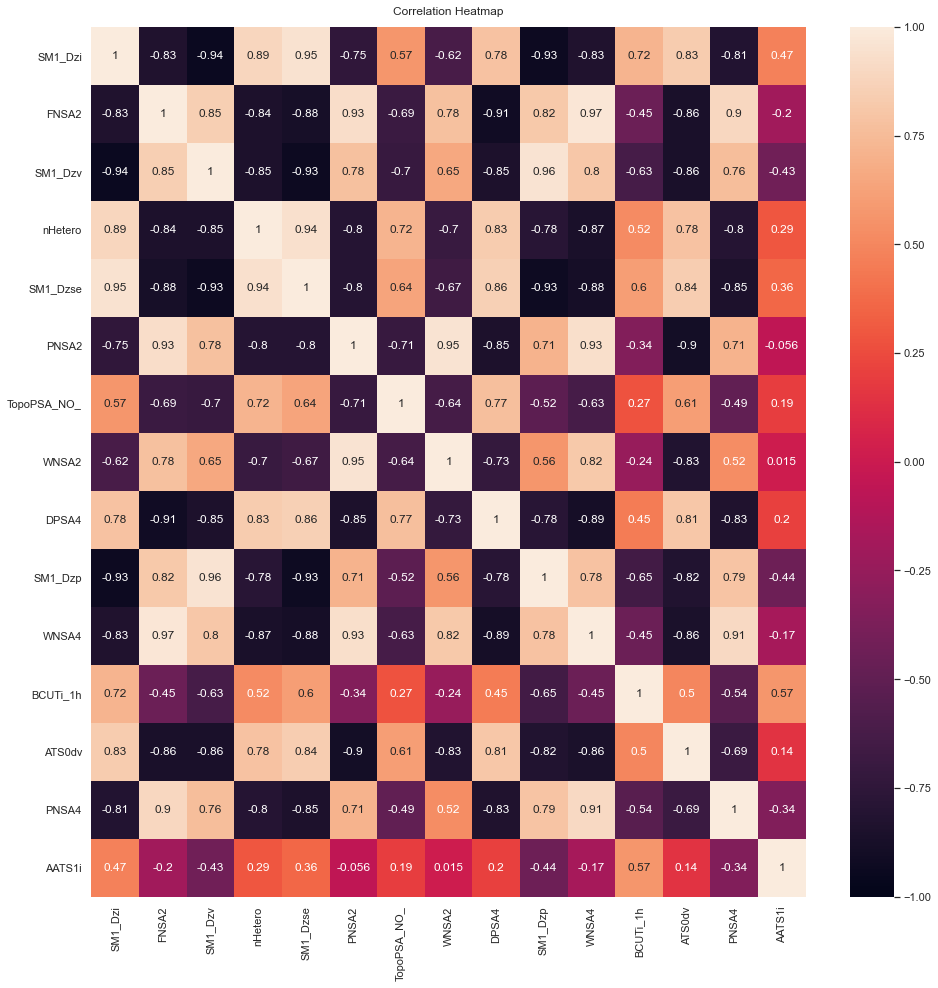

In [37]:
corrs_important_features(tuned_rf, X_test_rf, "random forest", 100, heatmap=15)

## Save dataframe used in RF to CSV
- i.e. dataframe with all columns with *any* missing values removed

In [38]:
rf_csv = df.loc[:,X_train_rf.columns]
rf_csv.to_csv('data/random-forest-df.csv')  
rf_csv

,SM1_Dzi,nHetero,FNSA2,AATS1are,TopoPSA_NO_,SM1_Dzp,SM1_Dzv,AMID_h,WNSA4,PNSA2,...,AATS0p,ETA_dPsi_A,AATSC1v,Mor18v,BCUTdv_1h,TPSA,piPC10,Xc_3dv,ATS2dv,fragCpx
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.692537,4,-0.915439,6.745000,74.60,-4.329177,-1.595978,0.537109,-5.349824,-305.043175,...,1.596873,0.234548,7.084554,-0.255126,6.023248,177.319844,4.123094,0.458203,371.000000,40.04
C(=C(F)F)(C(F)(F)F)C(F)(F)F,2.829626,8,-1.298106,9.159091,0.00,-15.985637,-4.373277,1.119786,-9.026518,-374.978099,...,1.136466,0.466475,-2.137667,-0.232827,7.018760,9.118632,0.000000,0.366495,615.000000,11.08
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.887688,10,-1.567908,8.023421,149.65,-9.130605,-3.750935,1.129690,-10.720464,-565.124164,...,1.378930,0.346270,3.859464,-0.214213,7.006317,312.014928,0.000000,0.399300,483.000000,16.10
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.755294,4,-0.627113,6.270000,32.67,-1.884713,-0.954355,0.386676,-4.384569,-301.226589,...,1.764181,0.108081,-0.411755,-0.875608,6.021984,57.422513,7.092158,0.641289,384.666667,104.04
C(C(C(F)(F)F)(F)Cl)(F)Cl,2.031838,7,-1.026223,8.340000,0.00,-9.523133,-2.566721,1.171331,-7.618910,-293.267269,...,1.806123,0.401500,-1.875157,-0.049354,7.014841,64.375260,0.000000,0.706937,339.444444,9.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.346268,2,-0.214952,6.113636,26.30,-2.164589,-0.797989,0.404834,-1.161034,-75.762912,...,1.175360,0.182085,-6.799773,-0.102164,6.028074,50.515484,0.000000,0.058926,88.000000,8.02
C=CCSS(=O)CC=C,-0.000667,3,-0.272162,5.927422,17.07,-0.234018,-0.083837,0.637150,-1.820266,-97.019306,...,2.033828,0.056105,1.192240,-0.107652,6.008268,39.320366,0.000000,0.433013,30.666667,8.03
CCCC(=O)OCC(C)C,0.346268,2,-0.222321,6.070000,26.30,-2.164589,-0.797989,0.368208,-1.193149,-83.047118,...,1.181208,0.167125,-6.025601,-0.115772,6.028075,45.749995,0.000000,0.467174,101.000000,9.02


# XgBoost

https://practicaldatascience.co.uk/machine-learning/how-to-create-a-classification-model-using-xgboost

In [39]:
# for readibility 
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

## Create model

In [40]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [41]:
# Baseline results
print("Baseline performance of XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Baseline performance of XGBoost
AVERAGE CV=5 ROC_AUC: 0.9683822923108636
AVERAGE CV=5 STD: 0.005960723988757947


(0.9683822923108636, 0.005960723988757947)

## Handle NaNs

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.971933,0.005894
1,0.1,0.966816,0.004796
2,0.2,0.967015,0.005358
3,0.3,0.969963,0.003741
4,0.4,0.968995,0.005546
5,0.5,0.967306,0.007980
6,0.6,0.968583,0.005718
7,0.7,0.967467,0.006074
8,0.8,0.967978,0.005662
9,0.9,0.968382,0.005961


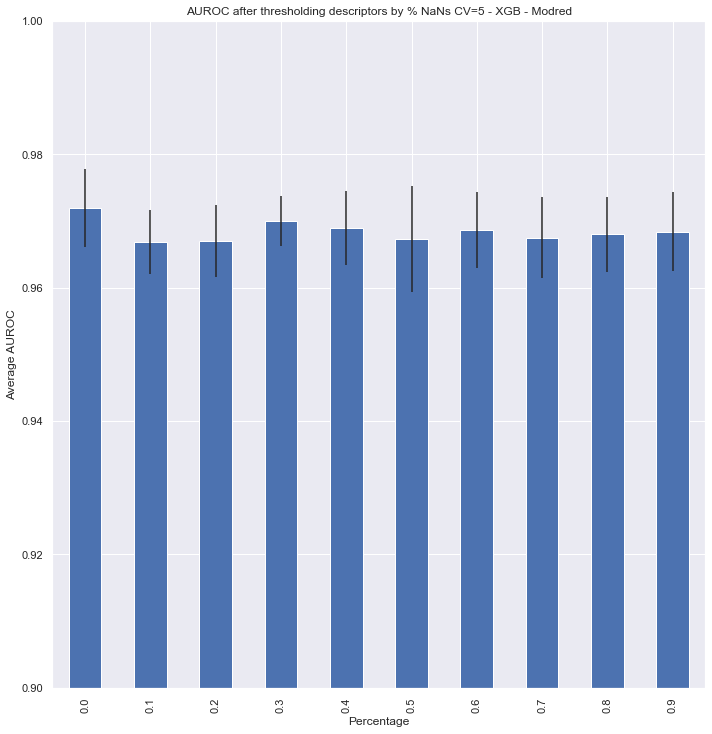

In [42]:
# choose optimal threshold for removing columns with NaNs
#IMPUTING 
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=2, model_name="XGB")

Cross validated missing values experiment with k=5


,Percentage,Average AUROC,Standard Deviation
0,0.0,0.971933,0.005894
1,0.1,0.972348,0.004199
2,0.2,0.969154,0.002365
3,0.3,0.966702,0.005326
4,0.4,0.970464,0.005563
5,0.5,0.970917,0.004148
6,0.6,0.970157,0.004485
7,0.7,0.971579,0.004544
8,0.8,0.971935,0.004502
9,0.9,0.971661,0.003854


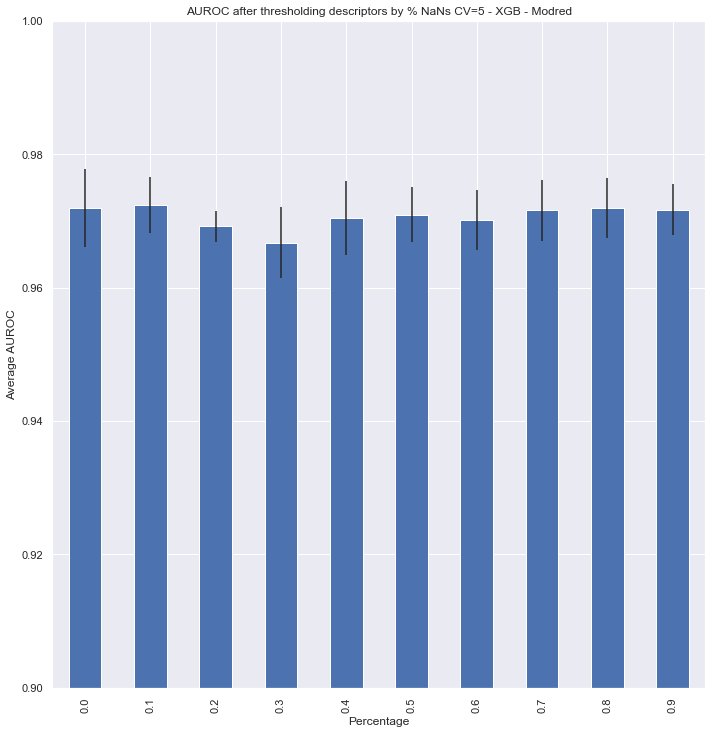

In [43]:
# choose optimal threshold for removing columns with NaNs
optimiseNaNs(xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, option=3, model_name="XGB")

In [44]:
X_train_xgb, X_test_xgb = handleNaNs(X_train.copy(), X_test.copy(), option=3, thresh=0.1)
X_train_t_xgb, X_val_xgb = handleNaNs(X_train_t.copy(), X_val.copy(), option=3, thresh=0.1)

In [45]:
xgb.fit(X_train_xgb, y_train_xgb)
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

AVERAGE CV=5 ROC_AUC: 0.9723479694908267
AVERAGE CV=5 STD: 0.004199411539426992


(0.9723479694908267, 0.004199411539426992)

## Importance Experiment XGB

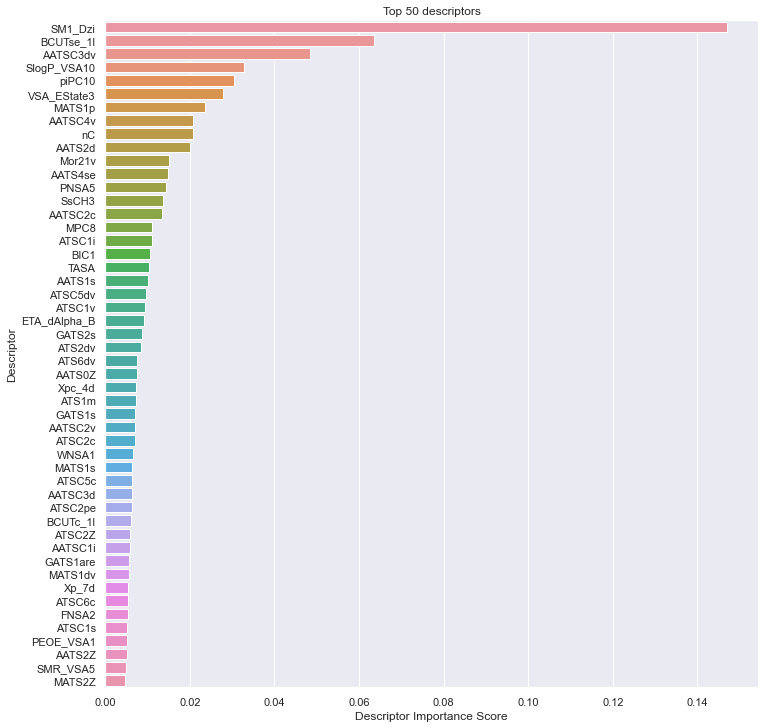

Cross validated importance experiment with k=5


,Most important N descriptors,Average AUROC,Standard Deviation
0,1.0,0.915450,0.018266
1,2.0,0.940405,0.014530
2,5.0,0.949024,0.012362
3,10.0,0.968048,0.006576
4,25.0,0.976230,0.003876
5,50.0,0.976365,0.002750
6,100.0,0.978863,0.001981
7,200.0,0.975660,0.001456
8,400.0,0.973980,0.001555
9,939.0,0.971898,0.002210


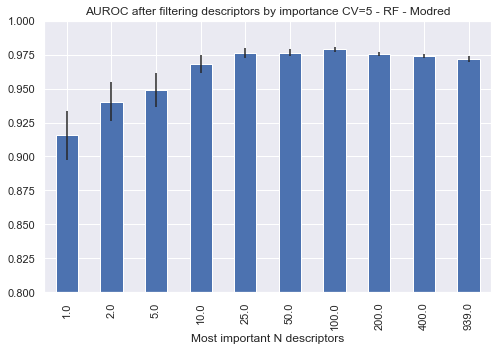

In [46]:
xgb.fit(X_train_xgb, y_train_xgb)
optimiseImportance(xgb, X_train_xgb, y_train_xgb)

AVERAGE CV=5 ROC_AUC: 0.9723479694908267
AVERAGE CV=5 STD: 0.004199411539426992


,Most important N descriptors,Average AUROC,Standard Deviation
0,0.0,0.972348,0.004199
1,5.0,0.969595,0.004337
2,10.0,0.967877,0.002720
3,25.0,0.964551,0.006826
4,50.0,0.965028,0.004877
5,100.0,0.966952,0.005585
6,200.0,0.954425,0.011988
7,400.0,0.956643,0.008045


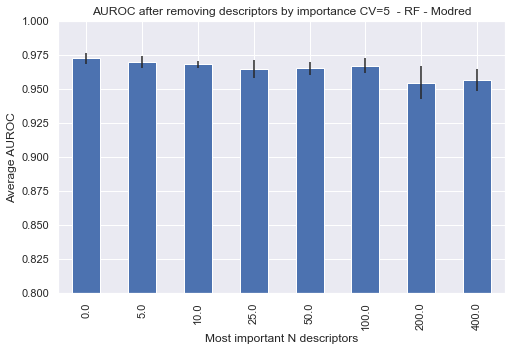

In [47]:
xgb.fit(X_train_xgb, y_train_xgb)
testWithoutImportantDescs(xgb, X_train_xgb, y_train_xgb)

In [48]:
X_train_xgb, X_test_xgb, xgb = handle_importance(xgb, 
                                                X_train_xgb, 
                                                X_test=X_test_xgb, 
                                                threshold=-1, 
                                                n=100)

X_train_t_xgb, X_val_xgb, xgb = handle_importance(xgb, 
                                                X_train_t_xgb, 
                                                X_test=X_val_xgb, 
                                                threshold=-1, 
                                                n=100)
xgb.fit(X_train_t_xgb, y_train_t)

# Filted importance results
print("Cross validated CV=5 performance after filtering by importance XGBoost")
test_model_cross_val(xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Cross validated CV=5 performance after filtering by importance XGBoost
AVERAGE CV=5 ROC_AUC: 0.9788631210059782
AVERAGE CV=5 STD: 0.0019808228652195507


(0.9788631210059782, 0.0019808228652195507)

In [49]:
X_train_xgb

,SM1_Dzi,BCUTse_1l,AATSC3dv,SlogP_VSA10,piPC10,VSA_EState3,MATS1p,AATSC4v,nC,AATS2d,...,RNCG,GATS1Z,ATSC0s,ATS3Z,WPSA3,ATSC4d,Mor06,AATSC0i,ABC,BCUTi_1h
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC(=CC=C1C(=O)O)[N+](=O)[O-],0.251059,0.211110,0.559844,0.092529,0.000000,0.453289,0.844813,0.458004,0.269231,0.566667,...,0.361196,0.079979,0.404049,0.231275,0.220724,0.751330,0.213801,0.108129,0.309821,0.693586
CCCCCCCCCCCCCCCCO,0.112811,0.283947,0.593918,0.000000,0.202413,0.291496,0.678271,0.506979,0.615385,0.216924,...,0.334358,0.498448,0.109650,0.295832,0.500888,0.713182,0.882935,0.085628,0.396431,0.589001
C1(C(O1)(F)F)(C(F)(F)F)F,0.506810,0.309601,0.568783,0.428571,0.000000,0.150825,0.509198,0.538457,0.115385,0.598958,...,0.204273,0.541644,0.400797,0.279223,0.014278,0.833401,0.325840,0.572335,0.274541,0.999104
CC(C)(C=C)O,0.112811,0.250243,0.505724,0.000000,0.000000,0.292553,0.650660,0.507975,0.192308,0.266667,...,0.630354,0.403480,0.106800,0.091507,0.095808,0.759402,0.268340,0.085536,0.140590,0.589004
C=CCC1=CC2=C(C=C1)OCO2,0.144954,0.210626,0.572091,0.000000,0.345379,0.150825,0.610314,0.476884,0.384615,0.520833,...,0.368721,0.155873,0.056232,0.219054,0.255838,0.662404,0.185198,0.098836,0.320683,0.589962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCS,0.064534,0.300411,0.590094,0.000000,0.000000,0.150825,0.591908,0.511104,0.153846,0.141667,...,0.505851,0.339069,0.005479,0.075212,0.076199,0.717719,0.277693,0.105610,0.099108,0.352868
CCN(CC)CC,0.122486,0.321492,0.557470,0.000000,0.000000,0.150825,0.471476,0.398158,0.230769,0.192308,...,0.639424,0.511308,0.014137,0.115638,0.089829,0.682655,0.211586,0.085553,0.148662,0.688045
C1=CC=C(C=C1)C(=O)C2=CC=CC=C2,0.112811,0.207331,0.604181,0.000000,0.557940,0.150825,0.714085,0.507459,0.500000,0.534188,...,0.334292,0.150591,0.141724,0.265747,0.198950,0.656557,0.156476,0.098841,0.372653,0.590455


## Tuning paramaters 

In [90]:
params = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
#    'subsample': (0.7, 1.0),  # Change for big datasets
    'colsample_bytree': (0.7, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5), 
    'reg_lambda': (0, 2),
    'reg_alpha':(0, 2),
    'scale_pos_weight': (1, 2.5)
    }

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        colsample_bytree,
                        gamma, 
                        reg_lambda, 
                        reg_alpha,
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    xgb_temp = XGBClassifier(
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda, 
        reg_alpha=reg_alpha,
        scale_pos_weight=scale_pos_weight,
        seed=SEED)
    
    # calculate CV=3 K fold ROC_AUC accuracy for each model 

    return np.array(cross_val_score(xgb_temp, X_train_xgb, y_train_xgb, cv=3, scoring='roc_auc')).mean()

optimizer = BayesianOptimization(
            f=xgboost_hyper_param,
            pbounds=params,
            random_state=SEED)

optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | scale_... |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9658    | 0.8646    | 3.576     | 0.6067    | 6.814     | 481.3     | 1.292     | 0.8752    | 2.338     |
| 2         | 0.9711    | 0.9891    | 1.917     | 0.7938    | 6.702     | 611.2     | 1.851     | 0.1421    | 1.131     |
| 3         | 0.9619    | 0.7061    | 4.163     | 0.7804    | 9.09      | 980.8     | 1.598     | 0.923     | 2.171     |
| 4         | 0.9742    | 0.7355    | 3.2       | 0.1519    | 9.613     | 569.7     | 0.8293    | 0.5291    | 2.161     |
| 5         | 0.9748    | 0.8368    | 2.842     | 0.0286    | 7.323     | 650.9     | 1.234     | 1.887     | 2.023     |
| 6         | 0.9646    | 0.7453    | 4.304     | 0.8063    | 9.984     | 690.3     | 0.3786    | 0.7181    | 1.568     |
| 7         | 0.9743    

| 41        | 0.9727    | 0.775     | 2.834     | 0.3286    | 6.081     | 652.3     | 1.918     | 0.6361    | 2.022     |
| 42        | 0.9745    | 0.8679    | 0.2771    | 0.2361    | 9.875     | 819.9     | 1.389     | 1.963     | 2.253     |
| 43        | 0.9745    | 0.807     | 1.218     | 0.1835    | 4.542     | 304.8     | 1.339     | 0.5865    | 2.246     |
| 44        | 0.9726    | 0.8371    | 0.191     | 0.4164    | 3.812     | 305.7     | 0.7358    | 1.828     | 2.144     |
| 45        | 0.9655    | 0.8619    | 2.216     | 0.6081    | 3.226     | 305.8     | 1.55      | 0.6531    | 1.3       |
| 46        | 0.9707    | 0.9197    | 0.5335    | 0.836     | 9.561     | 821.5     | 1.982     | 0.736     | 1.119     |
| 47        | 0.9745    | 0.8365    | 3.365     | 0.1727    | 5.939     | 651.1     | 0.3711    | 1.669     | 1.142     |
| 48        | 0.9637    | 0.9421    | 4.472     | 0.6587    | 5.941     | 650.8     | 1.459     | 1.376     | 1.738     |
| 49        | 0.9744    

In [91]:
params_tuned_xgb = optimizer.max['params']
params_tuned_xgb['max_depth'] = int(params_tuned_xgb['max_depth'])
params_tuned_xgb['n_estimators'] = int(params_tuned_xgb['n_estimators'])
print(params_tuned_xgb)

tuned_xgb = XGBClassifier(**params_tuned_xgb, seed=SEED)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

{'colsample_bytree': 0.806434816311709, 'gamma': 0.2700813460101427, 'learning_rate': 0.383267202672901, 'max_depth': 9, 'n_estimators': 820, 'reg_alpha': 1.1532194255543213, 'reg_lambda': 2.0, 'scale_pos_weight': 1.3154786375512288}
AVERAGE CV=5 ROC_AUC: 0.9768805400948258
AVERAGE CV=5 STD: 0.0016582768042814387


(0.9768805400948258, 0.0016582768042814387)

### Final tuned paramaters


In [92]:
# params = {'colsample_bytree': 0.8169037217345981, 'gamma': 0.6914223828184318, 'learning_rate': 0.03485637608005026, 'max_depth': 7, 'n_estimators': 759, 'reg_alpha': 1.342353161174468, 'reg_lambda': 0.7006577350782055, 'scale_pos_weight': 2.354475267911879}
# tuned_xgb = XGBClassifier(**params,
#                           seed=SEED,  
#                           n_jobs = -1)

print("Final tuned CV performance for XGB")
tuned_xgb.fit(X_train_xgb, y_train)
test_model_cross_val(tuned_xgb, y_train_xgb, X_train_xgb, k=5, verbose=True)

Final tuned CV performance for XGB
AVERAGE CV=5 ROC_AUC: 0.9768805400948258
AVERAGE CV=5 STD: 0.0016582768042814387


(0.9768805400948258, 0.0016582768042814387)

ROC_AUC (TEST): 0.9783739837398374


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.92      0.88      0.90        50
        True       0.95      0.97      0.96       123

    accuracy                           0.94       173
   macro avg       0.93      0.92      0.93       173
weighted avg       0.94      0.94      0.94       173



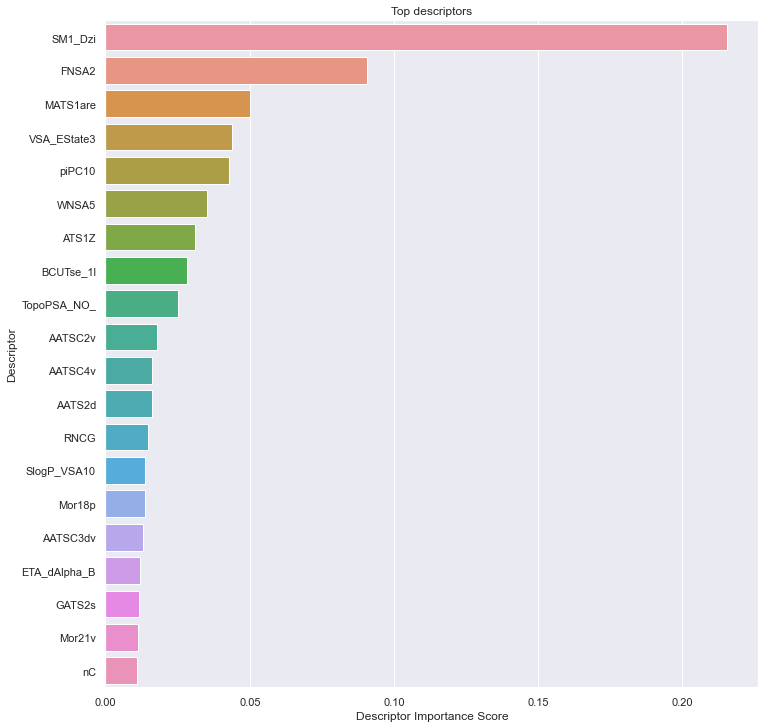

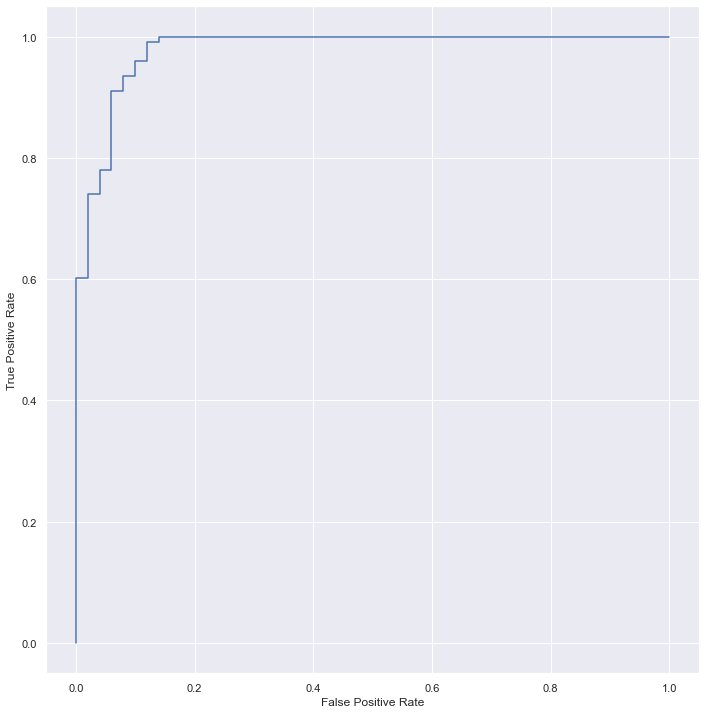

0.9783739837398374

In [93]:
tuned_xgb.fit(X_train_xgb, y_train_xgb)
test_model(tuned_xgb, y_test_xgb, X_test_xgb)

## Extract correlation for 'important' features

Extracted correlation scores for most important 100 features for xgb
Printing heatmap for most important 15 features


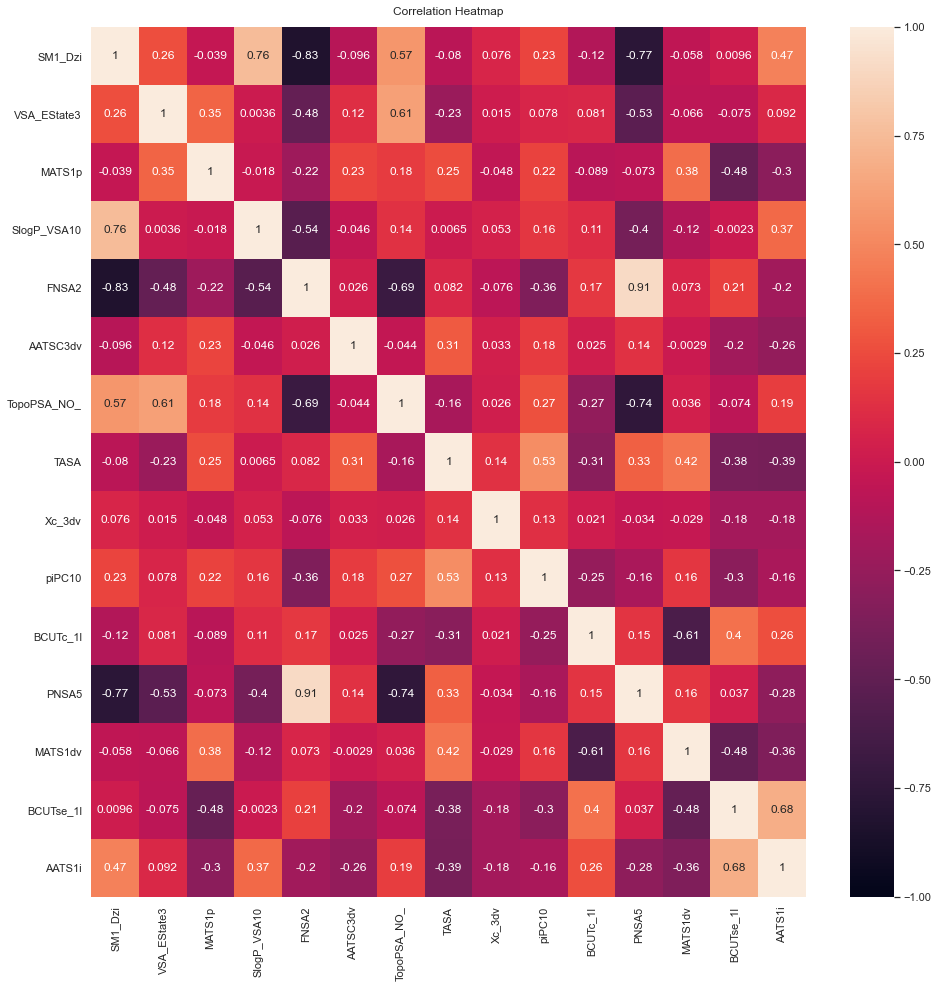

In [54]:
corrs_important_features(tuned_xgb, X_test_xgb, "xgb", 100, 15)

## Save dataframe used in XGB to CSV

In [55]:
rf_csv = df.loc[:,X_train_xgb.columns]
rf_csv.to_csv('data/xgb-df.csv')  
rf_csv

,SM1_Dzi,BCUTse_1l,AATSC3dv,SlogP_VSA10,piPC10,VSA_EState3,MATS1p,AATSC4v,nC,AATS2d,...,RNCG,GATS1Z,ATSC0s,ATS3Z,WPSA3,ATSC4d,Mor06,AATSC0i,ABC,BCUTi_1h
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C2C(=C1)C(=O)C(C2=O)(O)O,0.692537,2.433499,0.753001,0.000000,4.123094,18.218704,0.247672,-10.236431,9,4.625000,...,0.234666,0.685281,83.831140,1163,4.649287,-7.036011,-1.693949,1.372150,10.191572,13.638923
C(=C(F)F)(C(F)(F)F)C(F)(F)F,2.829626,2.492362,-2.000000,35.123320,0.000000,0.000000,-0.181818,5.878585,4,3.944444,...,0.128851,1.500000,114.289352,864,0.741232,14.583333,0.072413,8.439201,8.786807,17.435467
C1=C(C=C(C(=C1[N+](=O)[O-])O)[N+](=O)[O-])[N+](=O)[O-],1.887688,2.438368,-0.328769,17.062159,0.000000,40.214036,0.447657,-2.413158,6,4.535714,...,0.242987,0.501493,150.000000,1208,5.356307,-0.476454,-1.410220,1.524407,11.877237,14.598259
CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3,0.755294,2.428710,-0.199781,5.687386,7.092158,0.634380,-0.041280,-7.634955,16,3.982759,...,0.232948,0.552835,37.220250,1765,7.604270,-9.942149,-1.283554,1.515720,15.682318,14.549653
C(C(C(F)(F)F)(F)Cl)(F)Cl,2.031838,2.582453,-0.634079,21.952075,0.000000,-4.491512,-0.056855,7.277421,3,3.166667,...,0.207489,0.712625,124.197546,1728,0.401023,4.760331,0.644576,7.239227,7.220990,17.431803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCCC(=O)OCC,0.346268,2.565122,-0.363190,0.000000,0.000000,0.000000,-0.233754,-4.710884,7,2.000000,...,0.510466,1.073491,38.157005,442,3.929288,-2.882798,-1.419671,1.159913,5.766244,13.642649
C=CCSS(=O)CC=C,-0.000667,2.510636,0.194104,0.000000,0.000000,0.000000,0.197332,-0.789751,6,2.285714,...,0.370501,0.622673,39.265661,684,4.061878,-2.072022,-1.304309,1.667804,5.766244,13.631573
CCCC(=O)OCC(C)C,0.346268,2.560364,-0.125951,0.000000,0.000000,0.000000,-0.202970,11.006216,8,2.152174,...,0.484886,1.108444,39.017094,556,4.058134,-1.733728,-1.022684,1.166747,6.692130,13.642649


# Compare descriptors used by both models 

In [56]:
len(set(X_train_rf.columns) - set(X_train_xgb.columns))

72

In [57]:
len(set(X_train_xgb.columns) - set(X_train_rf.columns))

72

# Keras

https://www.pluralsight.com/guides/classification-keras

In [97]:
!pip install keras
!pip install scikeras

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# for readibility 
y_train_nn = y_train.copy()
y_test_nn = y_test.copy()
X_train_nn = X_train.copy()
X_test_nn = X_test.copy()

tf.random.set_seed(SEED)


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Preprocessing

### Handle NaNs 
- You can't have missing values in a Neural Network, so we choose to remove all columns with them (for now)

In [98]:
X_train_nn, X_test_nn = handleNaNs(X_train.copy(), X_test.copy(), option=1)
X_train_t_nn, X_val_nn = handleNaNs(X_train_t.copy(), X_val.copy(), option=1)

In [99]:
X_train_nn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692 entries, C1=CC(=CC=C1C(=O)O)[N+](=O)[O-] to CC(C)N
Columns: 736 entries, ABC to mZagreb2
dtypes: float64(736)
memory usage: 3.9+ MB


## Prepare a validation set
- Stratified 

In [100]:
y_train_t_nn, y_val_nn = y_train_t.copy(), y_val.copy()

### Encode class values as integers

Use adam optimizer so we don't have to specify learning rate, as is the case with gradient descent, and optimise for it

In [101]:
encoder = LabelEncoder()
encoder.fit(y_train_nn)
y_train_nn = encoder.transform(y_train_nn)
y_train_t_nn = encoder.transform(y_train_t_nn)
y_test_nn = encoder.transform(y_test_nn)
y_val_nn = encoder.transform(y_val_nn)

## Metrics

## Test model - Keras

In [102]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc', curve='ROC'),
]

In [64]:
def test_model_keras(model, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn): 
    # Plot training and validation auc 

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model roc_auc')
    plt.ylabel('ROC_AUC')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # Plot training and validation ROC curve

    y_pred_keras = model.predict(X_val_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val_nn, y_pred_keras)
    auc_v_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)

    y_pred_t_keras = model.predict(X_train_nn).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_nn, y_pred_t_keras)
    auc_t_keras = metrics.roc_auc_score(y_train_nn, y_pred_t_keras)

    plt.plot(fpr_keras, tpr_keras)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(['', 'Validation (area = {:.3f})'.format(auc_v_keras), 'Training (area = {:.3f})'.format(auc_t_keras)], loc='best')
    plt.show()
    plt.show()


## Baseline Single Layer model
- Overfitting quite a bit, you can see it when you compare the validation set auc and the auc for the training set 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 737)               543169    
                                                                 
 dense_1 (Dense)             (None, 1)                 738       
                                                                 
Total params: 543,907
Trainable params: 543,907
Non-trainable params: 0
_________________________________________________________________


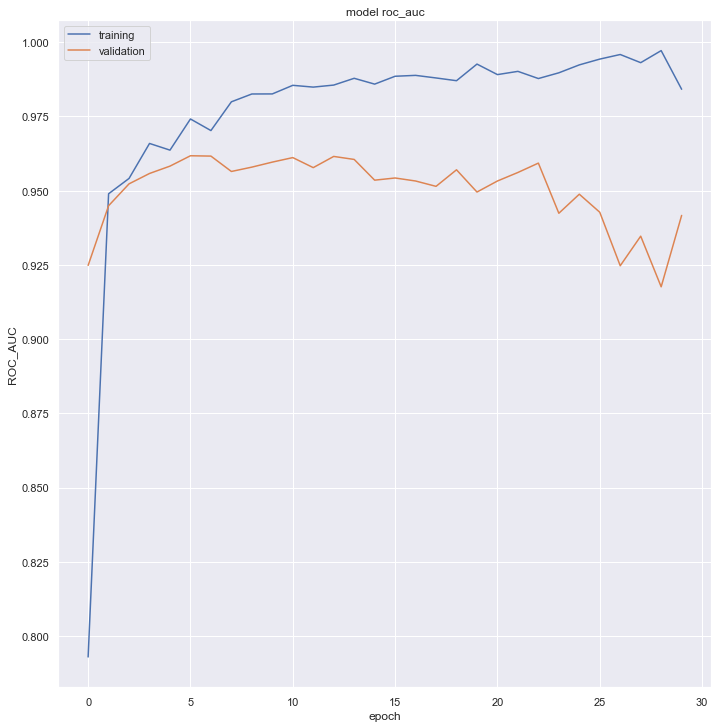

16/16 [==============================] - 0s 2ms/step


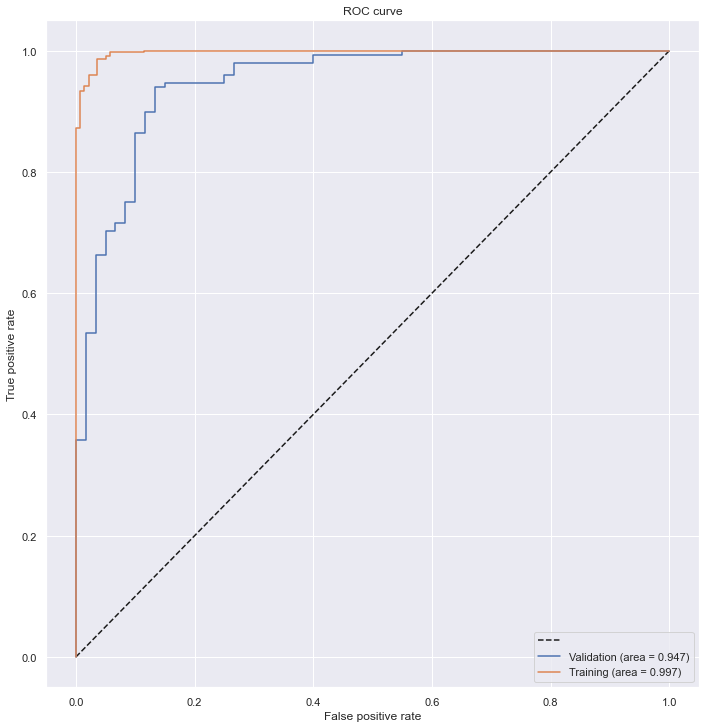

In [65]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train_nn.shape[-1]+1, activation="relu", input_shape=(X_train_nn.shape[-1],)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

history = model.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Tuning Multi Layer model

In [66]:
def model_builder(hp):

    model = keras.Sequential()
    model.add(Dense(X_train_t_nn.shape[-1], input_shape=(X_train_t_nn.shape[-1],), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=500, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=800, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Instantiate the tuner and perform hypertuning

https://www.tensorflow.org/tutorials/keras/keras_tuner The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer. Create a callback to stop training early after reaching a certain value for the validation loss.



To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

In [67]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)

tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 02s]
val_auc: 0.9467342495918274

Best val_auc So Far: 0.9541666507720947
Total elapsed time: 00h 00m 59s
INFO:tensorflow:Oracle triggered exit


In [68]:
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. 
 The optimal number of units in the first densely-connected
layer is 442 
 The optimal number of units in the second densely-connected
layer is 262 
 The optimal number of dropouts in the first densely-connected
layer is 0.30000000000000004.
 The optimal learning 
rate is  0.001



In [69]:
model3 = tuner.hypermodel.build(best_hps)
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 736)               542432    
                                                                 
 dense_5 (Dense)             (None, 442)               325754    
                                                                 
 dropout_1 (Dropout)         (None, 442)               0         
                                                                 
 dense_6 (Dense)             (None, 262)               116066    
                                                                 
 dense_7 (Dense)             (None, 1)                 263       
                                                                 
Total params: 984,515
Trainable params: 984,515
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
16/16 [==============================] - 1s 31ms/step - loss: 0.4749 - tp: 465.0000 - fp: 109.0000 - tn: 91.0000 - fn: 27.0000 - precision: 0.8101 - recall: 0.9451 - auc: 0.8351 - val_loss: 0.3136 - val_tp: 137.0000 - val_fp: 12.0000 - val_tn: 48.0000 - val_fn: 11.0000 - val_precision: 0.9195 - val_recall: 0.9257 - val_auc: 0.9275
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2748 - tp: 320.0000 - fp: 37.0000 - tn: 103.0000 - fn: 24.0000 - precision: 0.8964 - recall: 0.9302 - auc: 0.9417 - val_loss: 0.3036 - val_tp: 142.0000 - val_fp: 20.0000 - val_tn: 40.0000 - val_fn: 6.0000 - val_precision: 0.8765 - val_recall: 0.9595 - val_auc: 0.9532
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2810 - tp: 318.0000 - fp: 34.0000 - tn: 106.0000 - fn: 26.0000 - precision: 0.9034 - recall: 0.9244 - auc: 0.9399 - val_loss: 0.2597 - val_tp: 136.0000 - val_fp: 9.0000 - val_tn: 51.0000 - val_fn: 12.0000 - val_precision: 0.9379 - val_rec

Epoch 25/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1028 - tp: 340.0000 - fp: 15.0000 - tn: 125.0000 - fn: 4.0000 - precision: 0.9577 - recall: 0.9884 - auc: 0.9924 - val_loss: 0.3323 - val_tp: 140.0000 - val_fp: 8.0000 - val_tn: 52.0000 - val_fn: 8.0000 - val_precision: 0.9459 - val_recall: 0.9459 - val_auc: 0.9432
Epoch 26/30
16/16 [==============================] - 0s 13ms/step - loss: 0.0865 - tp: 336.0000 - fp: 12.0000 - tn: 128.0000 - fn: 8.0000 - precision: 0.9655 - recall: 0.9767 - auc: 0.9941 - val_loss: 0.4020 - val_tp: 138.0000 - val_fp: 8.0000 - val_tn: 52.0000 - val_fn: 10.0000 - val_precision: 0.9452 - val_recall: 0.9324 - val_auc: 0.9395
Epoch 27/30
16/16 [==============================] - 0s 12ms/step - loss: 0.0662 - tp: 340.0000 - fp: 7.0000 - tn: 133.0000 - fn: 4.0000 - precision: 0.9798 - recall: 0.9884 - auc: 0.9966 - val_loss: 0.4477 - val_tp: 142.0000 - val_fp: 16.0000 - val_tn: 44.0000 - val_fn: 6.0000 - val_precision: 0.8987 - val_recall

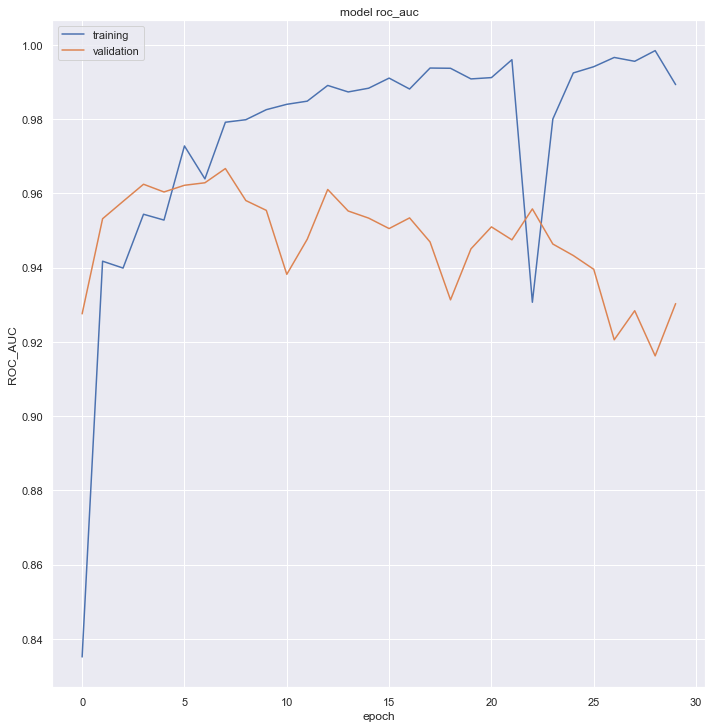

16/16 [==============================] - 0s 3ms/step


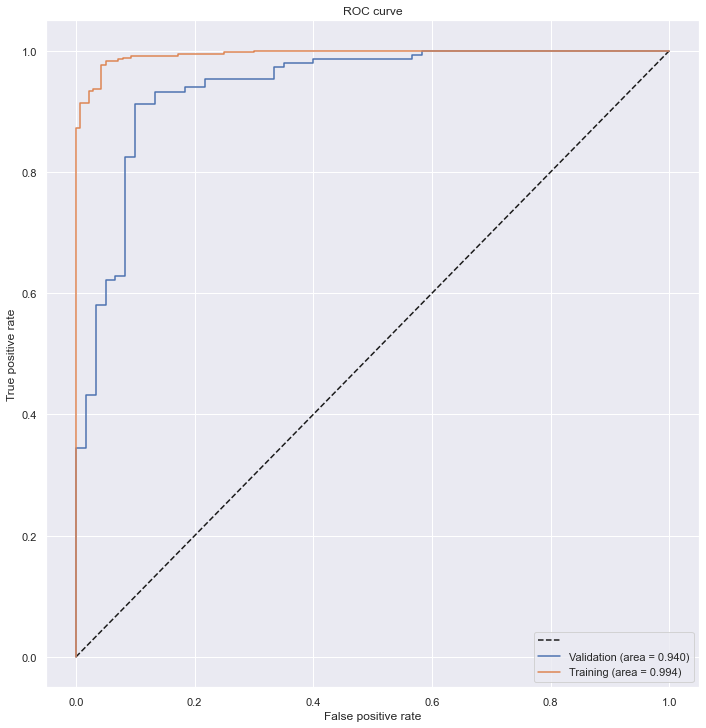

In [70]:
# Build the model with the optimal hyperparameters 
history = model3.fit( X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30, 
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=1)

test_model_keras(model3, history, X_val_nn, y_val_nn, X_train_t_nn, y_train_t_nn)

## Feature selection 

Using the set of the top 100 descriptors from RF and XGB, filter the dataset by these descriptors, and then measure validation accuracy

In [71]:
def model_builder_2(hp):

    model = keras.Sequential()
    model.add(Dense((X_train_t_nn_temp.shape[-1]), input_shape=((X_train_t_nn_temp.shape[-1]),), activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_3', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

### Use different algorithms for feature ranking

In [72]:
import sklearn.feature_selection as fs
from sklearn.svm import LinearSVC
import random

ranking = []
algos = ['random', 'rf', 'f_classif', 'mutual_info_classif']
ks = [5, 50, 100, 400, X_train_t_nn.shape[-1]]

accuracy_2 = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
  print(algo)
  
  for k in ks:
        print(k)

        X_train_t_nn_temp = X_train_t_nn.copy()
        X_val_nn_temp = X_val_nn.copy()
        
        if algo == 'random':
            indexes = list(range(X_train_t_nn.shape[-1]))
            random.shuffle(indexes)
            top_n = indexes[0:k]
            X_train_t_nn_temp = X_train_t_nn.iloc[:,top_n]
            X_val_nn_temp = X_val_nn.iloc[:,top_n]
        else:
            if algo == 'f_classif': 
                bk = fs.SelectKBest(fs.f_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == "mutual_info_classif":
                bk = fs.SelectKBest(fs.mutual_info_classif, k=k)
                bk.fit(X_train_t_nn, y_train_t_nn)
            elif algo == 'rf':
                tuned_rf.fit(X_train_t_nn_temp, y_train_t_nn)
                bk = fs.SelectFromModel(tuned_rf, prefit=True, max_features=k)
                
            X_train_t_nn_temp = bk.transform(X_train_t_nn)
            X_val_nn_temp = bk.transform(X_val_nn_temp)

        tuner = kt.Hyperband(model_builder_2,
                             objective=kt.Objective("val_auc", direction="max"),
                             max_epochs=10,
                             factor=3,
                             seed=SEED, 
                             directory="results_dir",
                             project_name="odor",
                             overwrite=True,)

        tuner.search(X_train_t_nn_temp, 
                     y_train_t_nn, 
                     epochs=30,
                     validation_data=(X_val_nn_temp, y_val_nn),
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  
        model_temp = tuner.hypermodel.build(best_hps)
        model_temp.summary()

        history = model_temp.fit(X_train_t_nn_temp, 
                             y_train_t_nn, 
                             epochs=30, 
                             validation_data=(X_val_nn_temp, y_val_nn), 
                             verbose=0)

        y_pred_keras = model_temp.predict(X_val_nn_temp).ravel()
        auc_keras = metrics.roc_auc_score(y_val_nn, y_pred_keras)
        accuracy_2.loc[k, algo] = auc_keras
        
        
accuracy_2

Trial 30 Complete [00h 00m 04s]
val_auc: 0.93659907579422

Best val_auc So Far: 0.9569819569587708
Total elapsed time: 00h 01m 22s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 736)               542432    
                                                                 
 dense_6 (Dense)             (None, 362)               266794    
                                                                 
 dropout_1 (Dropout)         (None, 362)               0         
                                                                 
 dense_7 (Dense)             (None, 1972)              715836    
                                                                 
 dense_8 (Dense)             (None, 342)               674766    
                                                                 
 dense_9 (Dense) 

,random,rf,f_classif,mutual_info_classif
5,0.834009,0.935248,0.894595,0.938119
50,0.922748,0.954617,0.951126,0.95045
100,0.953604,0.95518,0.952477,0.94786
400,0.942005,0.948649,0.947523,0.956869
736,0.942793,0.952703,0.950676,0.939077


Text(0, 0.5, 'ROC_AUC')

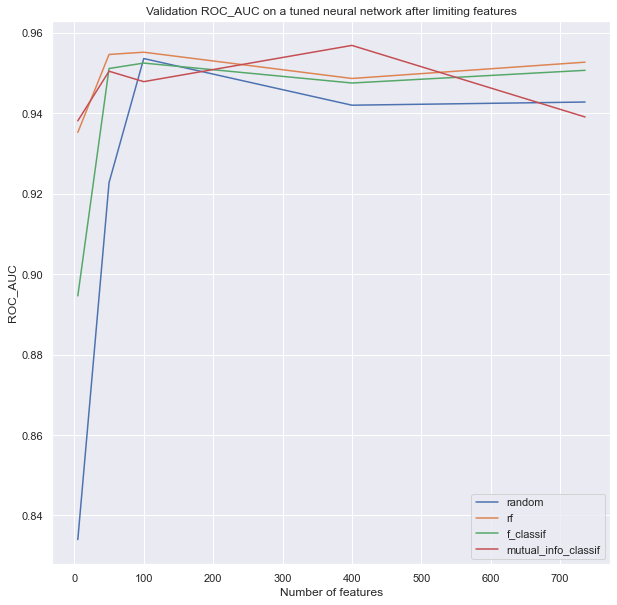

In [73]:
ax = accuracy_2.plot(figsize=(10, 10))
ax.set_title("Validation ROC_AUC on a tuned neural network after limiting features")
ax.set_xlabel("Number of features")
ax.set_ylabel("ROC_AUC")

Choose f_classif method of feature selection, with 100 features.
### Retune and retrain model

In [103]:
def model_builder_3(hp):

    model = keras.Sequential()
    model.add(Dense(X_train_nn.shape[-1], input_shape=(100,), activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_1', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # dropout layer reduces overfitting
    hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(keras.layers.Dropout(hp_units))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 2-length of layers
    hp_units = hp.Int('unit_2', min_value=2, max_value=2000, step=10)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=METRICS)

    return model

In [104]:
import sklearn.feature_selection as fs
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train_nn)
X_train_nn = constant_filter.transform(X_train_nn)
X_test_nn = constant_filter.transform(X_test_nn)
X_val_nn = constant_filter.transform(X_val_nn)
X_train_t_nn = constant_filter.transform(X_train_t_nn)


    
bk = fs.SelectKBest(fs.mutual_info_classif, k=400)
bk.fit(X_train_nn, y_train_nn)
X_train_nn = bk.transform(X_train_nn)

In [105]:
X_val_nn = bk.transform(X_val_nn)

In [106]:
X_test_nn = bk.transform(X_test_nn)

In [107]:
X_train_t_nn = bk.transform(X_train_t_nn)

In [108]:
print(X_val_nn.shape)
tuner = kt.Hyperband(model_builder_3,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_epochs=10,
                     factor=3,
                     seed=SEED, 
                     directory="results_dir",
                     project_name="odor",
                     overwrite=True,)
                     
tuner.search(X_train_t_nn, 
             y_train_t_nn, 
             epochs=30,
             validation_data=(X_val_nn, y_val_nn),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss")])

(208, 400)

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1242              |?                 |unit_1
0.05              |?                 |dropout_1
922               |?                 |unit_2
0.01              |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2


ValueError: in user code:

    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 400)


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. \n The optimal number of units in the first densely-connected
layer is {best_hps.get('unit_1')} \n The optimal number of units in the second densely-connected
layer is {best_hps.get('unit_2')} \n The optimal number of dropouts in the first densely-connected
layer is {best_hps.get('dropout_1')}.\n The optimal learning 
rate is  {best_hps.get('learning_rate')}
""")

In [ ]:
model4 = tuner.hypermodel.build(best_hps)
model4.summary()

In [109]:
history = model4.fit(X_train_t_nn, 
                      y_train_t_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/dense_4/Relu' defined at (most recent call last):
    File "/home/zoya/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/zoya/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/zoya/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/zoya/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/zoya/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-109-5c574c3e9434>", line 1, in <module>
      history = model4.fit(X_train_t_nn,
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/zoya/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/dense_4/Relu'
Matrix size-incompatible: In[0]: [64,400], In[1]: [100,100]
	 [[{{node sequential_1/dense_4/Relu}}]] [Op:__inference_train_function_2834037]

In [ ]:
model_final = tuner.hypermodel.build(best_hps)

# Build the final model with all the training data with the optimal hyperparameters 
history = model_final.fit(X_train_nn, 
                      y_train_nn, 
                      epochs=30,
                      batch_size=64,
                      validation_data=(X_val_nn, y_val_nn), 
                      verbose=0)

test_model_keras(model4, history, X_val_nn, y_val_nn, X_train_nn, y_train_nn)

## Evaluate model on test data

6/6 [==============================] - 0s 3ms/step


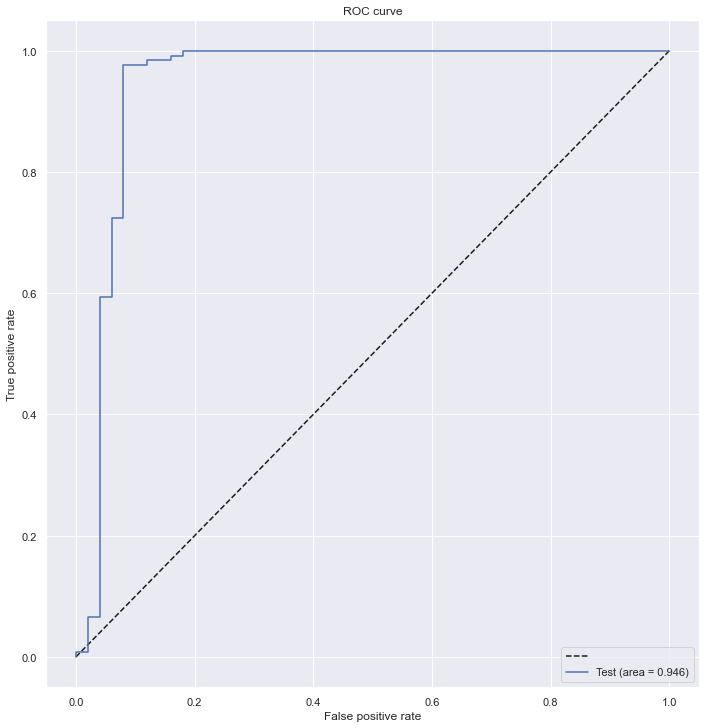

In [84]:
y_pred_t_keras = model_final.predict(X_test_nn).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_nn, y_pred_t_keras)
auc_t_keras = metrics.roc_auc_score(y_test_nn, y_pred_t_keras)
auc_t_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(['', 'Test (area = {:.3f})'.format(auc_t_keras)], loc='best')
plt.show()
plt.show()

# Penalized SVM

In [85]:
from sklearn import svm

y_train_svm = y_train.copy()
y_test_svm = y_test.copy()
X_train_svm, X_test_svm = handleNaNs(X_train.copy(), X_test.copy(), option=1)

In [86]:
clf_s = svm.SVC(kernel='linear',
                gamma='scale',
                class_weight='balanced', # penalize
                probability=True)

In [87]:
from sklearn.model_selection import RepeatedStratifiedKFold

print("Baseline CV=10 training performance of a SVM")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_svm, y_train_svm, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Baseline CV=10 training performance of a SVM
Mean ROC AUC: 0.951


In [88]:
print("CV=5 training performance of a SVM with RF most important descriptors")

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)
# evaluate model
scores = cross_val_score(clf_s, X_train_rf, y_train_rf, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

CV=5 training performance of a SVM with RF most important descriptors
Mean ROC AUC: 0.960


ROC_AUC (TEST): 0.9209756097560975


CLASSIFICATION REPORT:
               precision    recall  f1-score   support

       False       0.78      0.92      0.84        50
        True       0.96      0.89      0.93       123

    accuracy                           0.90       173
   macro avg       0.87      0.91      0.89       173
weighted avg       0.91      0.90      0.90       173



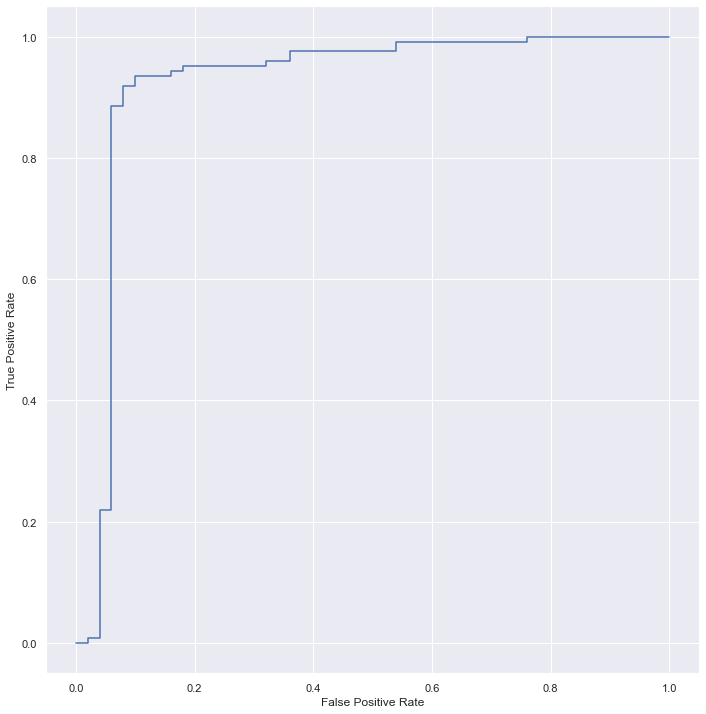

0.9209756097560975

In [89]:
clf_s.fit(X_train_rf, y_train_rf)
test_model(clf_s, y_test_rf, X_test_rf)